In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import os
print(os.listdir("../input"))
import pathlib

['predict the news category']


In [12]:
np.random.seed(1)

In [14]:
train = pd.read_excel('../input/predict the news category/Data_Train.xlsx')
test = pd.read_excel('../input/predict the news category/Data_Test.xlsx')
sub = pd.read_excel('../input/predict the news category/Sample_submission.xlsx');

In [15]:
train.shape, test.shape

((7628, 2), (2748, 1))

In [16]:
train.head(2)

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0


In [17]:
test.head(2)

,STORY
0,2019 will see gadgets like gaming smartphones ...
1,It has also unleashed a wave of changes in the...


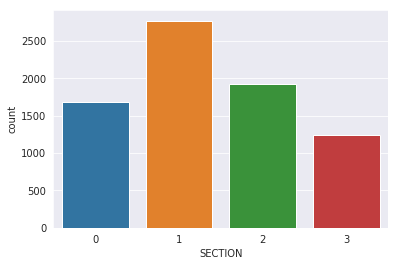

In [18]:
sns.countplot(x='SECTION', data=train)

In [19]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/optimization.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/run_classifier.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py

--2019-08-22 03:16:22--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 2607:f8b0:4001:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   146MB/s    in 2.7s    

2019-08-22 03:16:25 (146 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

--2019-08-22 03:16:26--  https://raw.githubusercontent.com/google-research/bert/master/modeling.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37922 (37K) [text/pl

In [20]:
import modeling
import optimization
import run_classifier
import tokenization

In [21]:
import zipfile
folder = 'model_folder'
with zipfile.ZipFile("uncased_L-12_H-768_A-12.zip","r") as zip_ref:
    zip_ref.extractall(folder)

In [22]:
BERT_MODEL = 'uncased_L-12_H-768_A-12'
BERT_PRETRAINED_DIR = f'{folder}/uncased_L-12_H-768_A-12'
OUTPUT_DIR = f'{folder}/outputs'
print(f'>> Model output directory: {OUTPUT_DIR}')
print(f'>>  BERT pretrained directory: {BERT_PRETRAINED_DIR}')

>> Model output directory: model_folder/outputs
>>  BERT pretrained directory: model_folder/uncased_L-12_H-768_A-12


In [23]:
train["SECTION"].values.astype(int)

array([3, 0, 3, ..., 1, 0, 2])

In [24]:
def create_examples(lines, set_type, labels=None):
#Generate data for the BERT model
    guid = f'{set_type}'
    examples = []
    if guid == 'train':
        for line, label in zip(lines, labels):
            text_a = line
            label = str(label)
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    else:
        for line in lines:
            text_a = line
            label = '0'
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

In [26]:
import tensorflow as tf
import random
random.seed(1)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=6, inter_op_parallelism_threads=5)
from keras import backend

Using TensorFlow backend.


In [32]:
# Model Hyper Parameters
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 32
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 5
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 200

# Model configs
SAVE_CHECKPOINTS_STEPS = 100000  
ITERATIONS_PER_LOOP = 100000
NUM_TPU_CORES = 8
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
DO_LOWER_CASE = BERT_MODEL.startswith('uncased')

In [33]:
label_list = [0,1,2,3]
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)
train_examples = create_examples(train["STORY"].values, 'train', labels=train["SECTION"].values.astype(int))

tpu_cluster_resolver = None #Since training will happen on GPU, we won't need a cluster resolver
#TPUEstimator also supports training on CPU and GPU. You don't need to define a separate tf.estimator.Estimator.
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

In [34]:
num_train_steps = int(
    len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

model_fn = run_classifier.model_fn_builder(
    bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
    num_labels=len(label_list),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available  
    use_one_hot_embeddings=True)

In [35]:
estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available 
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE)

In [36]:
import datetime
print('Please wait...')
train_features = run_classifier.convert_examples_to_features(train_examples,{'0':0,'1':1,'2':2, '3':3}, MAX_SEQ_LENGTH, tokenizer)
print('>> Started training at {} '.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_examples)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print('>> Finished training at {}'.format(datetime.datetime.now()))

Please wait...
>> Started training at 2019-08-22 03:21:33.974862 
  Num examples = 7628
  Batch size = 32
>> Finished training at 2019-08-22 03:38:46.914279


In [37]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    all_label_ids = []
    
    for feature in features:
        all_input_ids.append(feature.input_ids)
        all_input_mask.append(feature.input_mask)
        all_segment_ids.append(feature.segment_ids)
        all_label_ids.append(feature.label_id)
    
    def input_fn(params):
        """The actual input function."""
        print(params)
        batch_size = 500

        num_examples = len(features)

        d = tf.data.Dataset.from_tensor_slices({
            "input_ids":
                tf.constant(
                    all_input_ids, shape=[num_examples, seq_length],
                    dtype=tf.int32),
            "input_mask":
                tf.constant(
                    all_input_mask,
                    shape=[num_examples, seq_length],
                    dtype=tf.int32),
            "segment_ids":
                tf.constant(
                    all_segment_ids,
                    shape=[num_examples, seq_length],
                    dtype=tf.int32),
            "label_ids":
                tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

        if is_training:
            d = d.repeat()
            d = d.shuffle(buffer_size=100)

        d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
        return d

    return input_fn

In [38]:
predict_examples = create_examples(test['STORY'].values, 'test')

predict_features = run_classifier.convert_examples_to_features(
    predict_examples, {'0':0,'1':1,'2':2,'3':3}, MAX_SEQ_LENGTH, tokenizer)

predict_input_fn = input_fn_builder(
    features=predict_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

result = estimator.predict(input_fn=predict_input_fn)

In [40]:
preds = []
for prediction in result:
      preds.append(np.argmax(prediction['probabilities']))

{}


In [41]:
sub['SECTION'] = preds
sub.head()

,SECTION
0,1
1,2
2,1
3,0
4,1


In [42]:
sub['SECTION'].value_counts()

1    1182
2     823
0     424
3     319
Name: SECTION, dtype: int64

In [43]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(sub)